# Quality Control and Clustering

In [ ]:
!pip install scvelo
!pip install pyomic
!pip install anndata

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install
!pip install Pygments==2.14.0
install()
import scvi

In [ ]:

# Loading
import anndata
print('anndata(Ver): ',anndata.__version__)
import scanpy as sc
print('scanpy(Ver): ',sc.__version__)
#import scltnn 
#print('scltnn(Ver): ',scltnn.__version__)
import matplotlib.pyplot as plt
import matplotlib
print('matplotlib(Ver): ',matplotlib.__version__)
import seaborn as sns
print('seaborn(Ver): ',sns.__version__)
import numpy as np
print('numpy(Ver): ',np.__version__)
import pandas as pd
print('pandas(Ver): ',pd.__version__)
import scvelo as scv
print('scvelo(Ver): ',scv.__version__)
import Pyomic
print('Pyomic(Ver): ',Pyomic.__version__)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# plot settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [ ]:
sc_color=['#7CBB5F',
 '#368650',
 '#A499CC',
 '#5E4D9A',
 '#78C2ED',
 '#866017',
 '#9F987F',
 '#E0DFED',
 '#EF7B77',
 '#279AD7',
 '#F0EEF0',
 '#1F577B',
 '#A56BA7',
 '#E0A7C8',
 '#E069A6',
 '#941456',
 '#FCBC10',
 '#EAEFC5',
 '#01A0A7',
 '#75C8CC',
 '#F0D7BC',
 '#D5B26C',
 '#D5DA48',
 '#B6B812',
 '#9DC3C3',
 '#A89C92',
 '#FEE00C',#深黄
 '#FEF2A1']

# batch size correction

In [ ]:
adata = sc.read_h5ad('/content/drive/MyDrive/Gastric/Origin_sc/Gastric_Origin.h5ad')

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

filtered out 4655 cells that have less than 200 genes expressed
filtered out 28804 genes that are detected in less than 3 cells


In [ ]:
adata = adata[adata.obs.pct_counts_mt < 30, :]
adata.layers["counts"] = adata.X.copy() # preserve counts
adata.write('/content/drive/MyDrive/Gastric/Data/Gastric_Origin_new.h5ad',compression='gzip')
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata.raw=adata
adata = adata[:,adata.var['highly_variable']==True]
adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


View of AnnData object with n_obs × n_vars = 63786 × 2000
    obs: 'Group_number', 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [ ]:
adata = adata.copy()
# Batch size correction
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="Group_number",
)
model = scvi.model.SCVI(adata)
model.train()
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 125/125: 100%|██████████| 125/125 [54:16<00:00, 25.44s/it, loss=117, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=125` reached.


Epoch 125/125: 100%|██████████| 125/125 [54:16<00:00, 26.05s/it, loss=117, v_num=1]


In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:04:46)


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:38)
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:14)
Storing dendrogram info using `.uns['dendrogram_Group_number']`


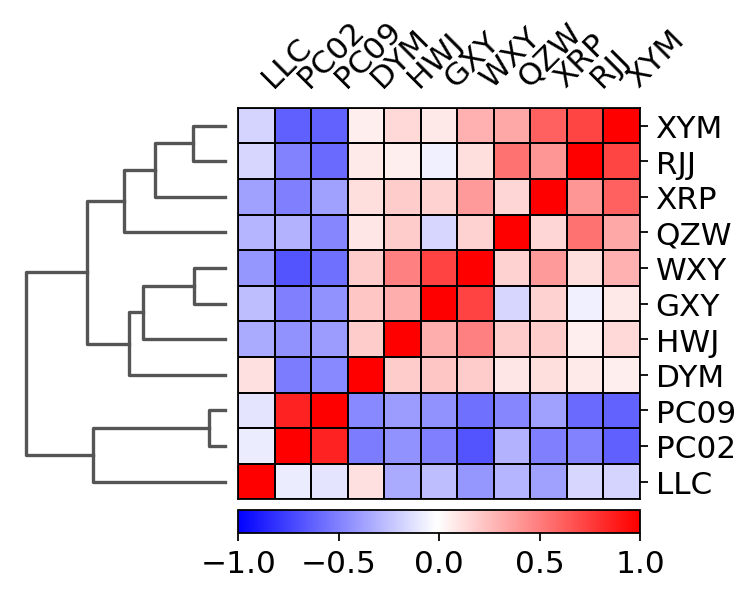

In [ ]:
#sc.tl.pca(adata, n_comps=100, svd_solver="arpack")
sc.pp.neighbors(adata, use_rep="X_scVI", metric="cosine",n_neighbors=20, random_state = 112)
sc.tl.dendrogram(adata, 'Group_number')
ax = sc.pl.correlation_matrix(adata, 'Group_number', figsize=(5,3.5))


In [ ]:
sc.tl.pca(adata, n_comps=100, svd_solver="arpack")
sc.pp.neighbors(adata, use_rep="X_scVI", metric="cosine",n_neighbors=20, random_state = 112)
sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata,init_pos='paga')

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:06)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:44)
running Leiden clustering
    finished: found 64 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:29)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:08)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:00)


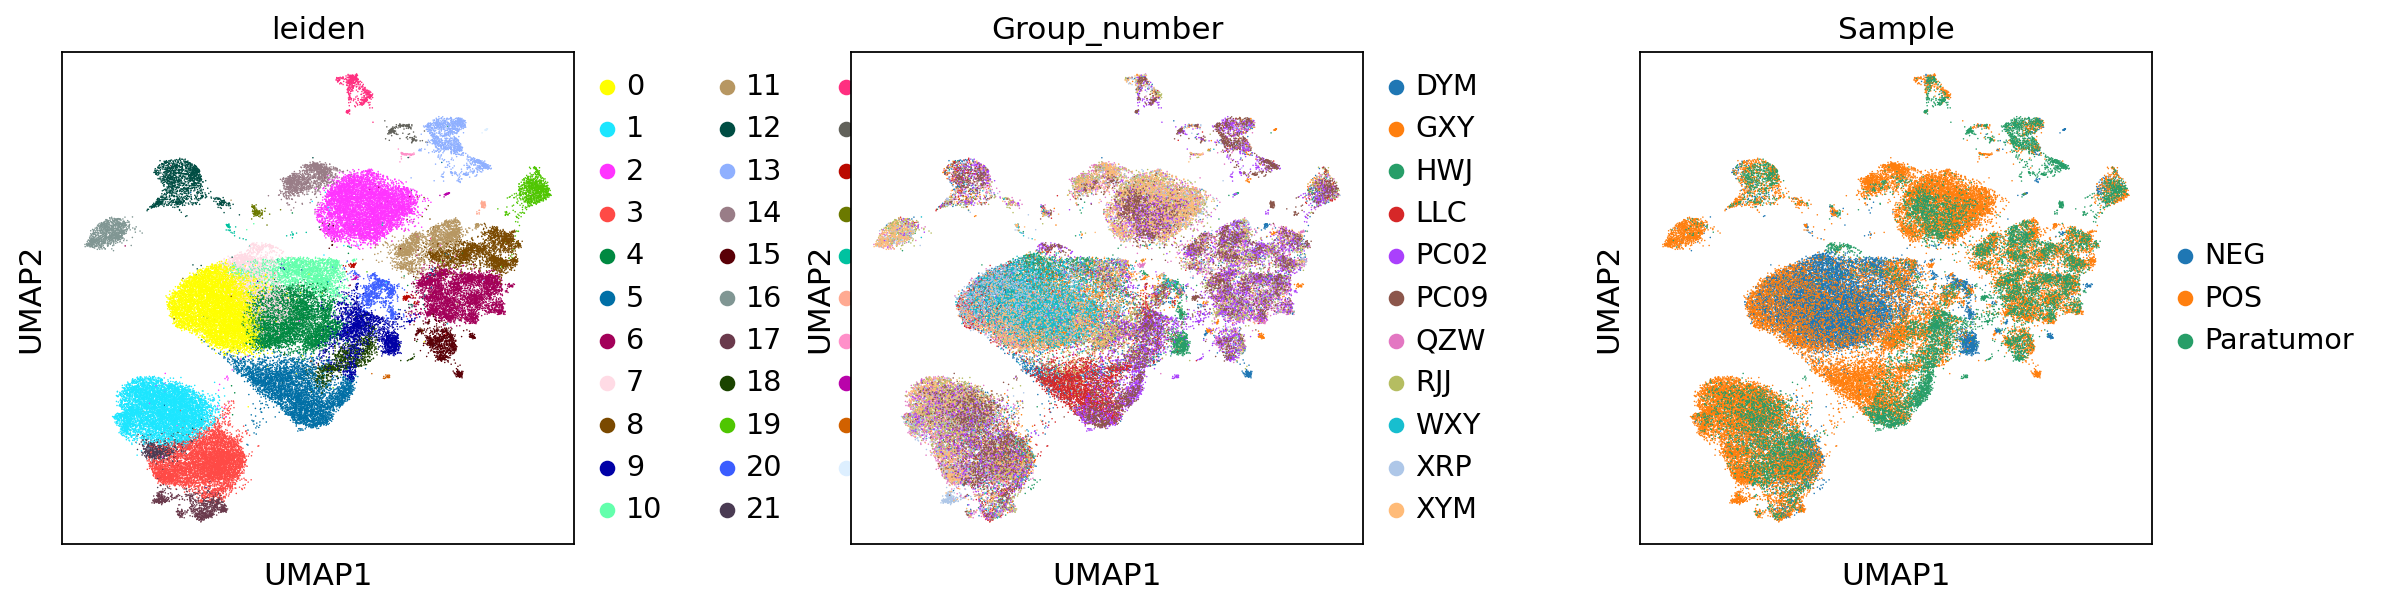

In [ ]:
sc.pl.umap(adata,color=['leiden','Group_number','Sample'],wspace=0.4)

In [ ]:
for i in adata.obs['leiden'].cat.categories:
  number = len(adata.obs[adata.obs['leiden']==i])
  print('the number of category {} is {}'.format(i,number))

the number of category 0 is 8357
the number of category 1 is 6713
the number of category 2 is 6645
the number of category 3 is 5852
the number of category 4 is 4981
the number of category 5 is 4732
the number of category 6 is 3893
the number of category 7 is 2915
the number of category 8 is 2208
the number of category 9 is 2198
the number of category 10 is 2176
the number of category 11 is 1803
the number of category 12 is 1432
the number of category 13 is 1285
the number of category 14 is 1277
the number of category 15 is 1007
the number of category 16 is 985
the number of category 17 is 941
the number of category 18 is 929
the number of category 19 is 909
the number of category 20 is 808
the number of category 21 is 581
the number of category 22 is 485
the number of category 23 is 175
the number of category 24 is 111
the number of category 25 is 105
the number of category 26 is 80
the number of category 27 is 72
the number of category 28 is 48
the number of category 29 is 42
the numb

In [ ]:
adata.write('/content/drive/MyDrive/Gastric/Data/Gastric_Origin.h5ad',compression='gzip')